**High performance computing- Taxi rides analysis**

In this project, we will analyze the following characteristics from New York taxi rides data:
* Average speed of taxis in terms of the hour.
* Most common taxi trips.
* Financial records (tips, persons, etc).

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


spark = SparkSession.builder.master('local[8]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark


 Ahora, vamos a hacer el Average speed of taxis in terms of the hour, con DataFrames

In [2]:
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("datostaxi")
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-10-01 00:30:44|  2024-10-01 00:48:26|              1|          3.0|         1|                 N|         162|         246|           1|       18.4|  1.0|    0.5|       1.

In order to test the code, we have imported the taxi rides for the whole of 2024.

In [3]:
df.count()

41169720

**AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR**

In this first section of the code, we will calculate the average speed of taxis for each hour of the day using RRDs. We will then compare these results with the ones achieved with pandas dataframes and employing SQL queries.
We begin by importing the time module, to measure the execution time of the code.

In [4]:
import time
start = time.time()

From the files read, in this first section of the project, the only columns needed are:trip distance, tpep_pickup_datetime,tpep_dropoff_datetime.

In [5]:
df2=df.select(["tpep_pickup_datetime","tpep_dropoff_datetime","trip_distance"])

The "tpep_pickup_datetime" and "tpep_dropoff_datetime" columns are given in a date-time format. They are transformed into unix timestamp, which is the number of seconds since January 1st, 1970. To do so, two new columns named "pickup" and "dropoff" are created. Then the rows with the same dropoff and pickup times are filtered, as well as those whose trip distance is less than or equal to 0.

In [6]:
from pyspark.sql.functions import (col, to_unix_timestamp, from_unixtime, hour, avg, count, round, lit)

#añadimos las columnas con el unix time stamp
base = (df2
    .withColumn("pickup", to_unix_timestamp(col("tpep_pickup_datetime"), lit( "yyyy-MM-dd HH:mm:ss")))
    .withColumn("dropoff", to_unix_timestamp(col("tpep_dropoff_datetime"),  lit("yyyy-MM-dd HH:mm:ss"))))
    
base2= base.filter(col("pickup") != col("dropoff")).filter(col("trip_distance")>0)



Then, the columns with the date-time format are eliminated from the dataframe. Only those with the unix timestamp and the trip distance are kept.

In [7]:
df_unix_times = base2.select("pickup", "dropoff","trip_distance")



The next step is to transform the dataframe into an RDD, to exploit the capabilities of the spark framework. The number of rows of the clean data set is also calculated.

In [8]:
rdd2 = df_unix_times.rdd



In [9]:
rdd2.take(5)

[Row(pickup=1727742644, dropoff=1727743706, trip_distance=3.0),
 Row(pickup=1727741540, dropoff=1727742325, trip_distance=2.2),
 Row(pickup=1727741086, dropoff=1727741632, trip_distance=2.7),
 Row(pickup=1727741530, dropoff=1727742181, trip_distance=3.1),
 Row(pickup=1727742680, dropoff=1727742960, trip_distance=0.97)]

rdd2 is an RDD of rows. Applying a map and a lambda, it is transformed into an RDD of tuples.

In [10]:
rdd_times = rdd2.map(lambda x: (
    x.pickup,    
    x.dropoff,   
    x.trip_distance))
rdd_times.take(5)

[(1727742644, 1727743706, 3.0),
 (1727741540, 1727742325, 2.2),
 (1727741086, 1727741632, 2.7),
 (1727741530, 1727742181, 3.1),
 (1727742680, 1727742960, 0.97)]

Then, the RDD is transformed. In the first column, the duration of the trip is calculated. The second column includes the distance, and finally, the last column contains the pickup time. The pickup time will be employed as the reference for the hour the taxi ride was taken..

In [11]:
rdd_diff = rdd_times.map(lambda x: ((x[1] - x[0]), x[2], x[0]))
rdd_diff.take(5)

[(1062, 3.0, 1727742644),
 (785, 2.2, 1727741540),
 (546, 2.7, 1727741086),
 (651, 3.1, 1727741530),
 (280, 0.97, 1727742680)]

Having the key parameters, the speed is now calculated. It is important to take into account that currently, the distance is in miles and the duration is in seconds. Therefore, when calculating distance/time, it is necessary to apply a change of units, so the results are in km/h. In addition, two different filters are applied. A first filter, that eliminates rows with a duration time smaller than 30 seconds. This is done so that the denominator of the fraction when computing the speed is not small, which could lead to disproportionately large speeds. The second filter, discards rows with calculated speeds greater than 150. This gives a large margin, as in New York, the real speeds of cars are significantly less. However, it gets rid of possible calculation errors, as previously commented.

In [12]:
import datetime
rdd_speed = rdd_diff.filter(lambda x: x[0] > 30).map(lambda x: (datetime.datetime.fromtimestamp(x[2]).hour,                                                            (x[1]* 1.60934 * 3600 / x[0], 1))).filter(lambda x: 0< x[1][0] < 150)

rdd_speed.take(5)

[(0, (16.366169491525426, 1)),
 (0, (16.23690802547771, 1)),
 (0, (28.64978901098901, 1)),
 (0, (27.588685714285717, 1)),
 (0, (20.070768857142856, 1))]

Now, the structure of the RDD is the following. The key, contains the hour the taxi ride was taken at.Then the couple is composed of two values. Fisrt, the speed of the taxi ride and second, a 1, that will be used to count the number of taxi rides in each hour.

To continue, we reduce by key. The reduce will add all of the speeds of the taxi rides for each hour, which have the same key. Then, by adding the 1, the number of taxi rides will be counted.

In [13]:
rdd_byhour = rdd_speed.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

rdd_byhour.take(5)

[(0, (26400118.86367584, 1164656)),
 (12, (33106149.726827495, 2140703)),
 (1, (16820278.810445514, 752903)),
 (13, (34531059.54971103, 2227096)),
 (2, (10961790.548305279, 488733))]

Currently, each value contains the sum of all the speeds and the number of taxi rides in each hour. The average is calculated by dividing both values using a map.

In [14]:
rdd_avgspeed = rdd_byhour.map(lambda x: (x[0], x[1][0]/x[1][1]))
rdd_avgspeed.take(5)   

[(0, 22.667739541698012),
 (12, 15.465083071695371),
 (1, 22.340565531609666),
 (13, 15.504971294327246),
 (2, 22.42899609460642)]

The RRD is then sorted by key.

In [15]:
rdd_final = rdd_avgspeed.sortByKey()
rdd_final.take(5)

[(0, 22.667739541698012),
 (1, 22.340565531609666),
 (2, 22.42899609460642),
 (3, 24.307489284121033),
 (4, 29.13665085515236)]

The final RDD is collected. It is transformed back to a data frame.

In [16]:
datos_speed=rdd_final.collect()

**Graphical Representation**

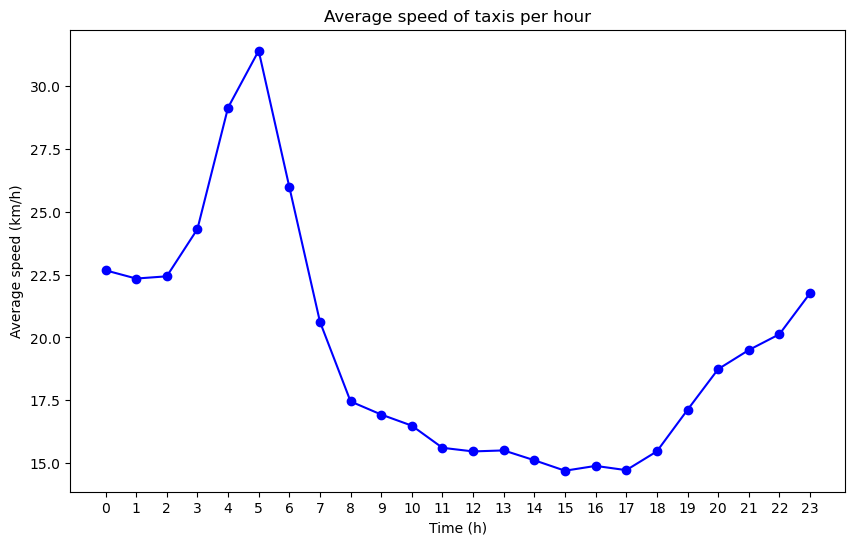

In [17]:
import matplotlib.pyplot as plt

hour = [x[0] for x in datos_speed]
vel = [x[1] for x in datos_speed]

plt.figure(figsize=(10,6))
plt.plot(hour, vel, marker='o', linestyle='-', color='blue')
plt.title("Average speed of taxis per hour")
plt.xlabel("Time (h)")
plt.ylabel("Average speed (km/h)")
plt.xticks(range(0,24))  
plt.show()

In [18]:
end = time.time()
print(f"Execution time: {end - start:.2f} s")

Execution time: 132.73 s


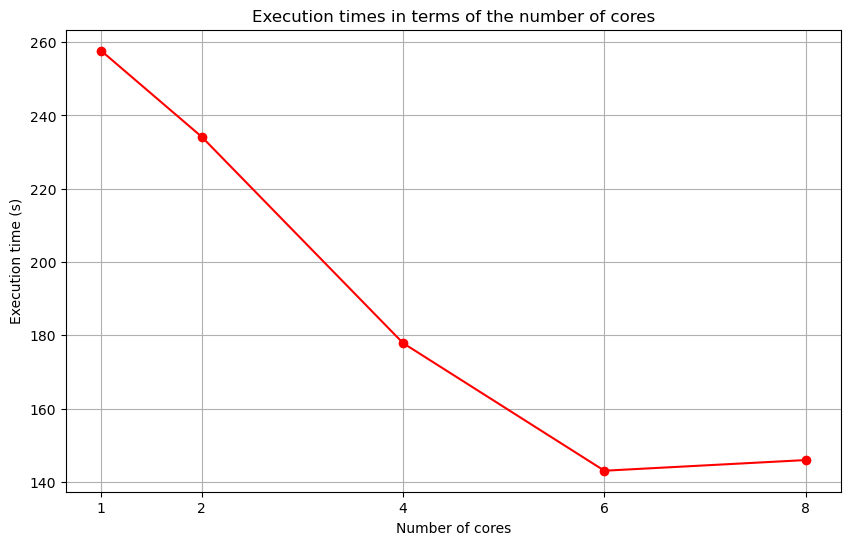

In [19]:
import matplotlib.pyplot as plt

cores = [1, 2, 4, 6, 8]
times = [257.66, 234.16, 177.88, 143.06, 145.97]

plt.figure(figsize=(10,6))
plt.plot(cores, times, marker='o', linestyle='-', color='red')
plt.title("Execution times in terms of the number of cores")
plt.xlabel("Number of cores")
plt.ylabel("Execution time (s)")
plt.xticks(cores)  
plt.grid(True)
plt.show()

The graphical representation above shows the execution times in terms of the number of cores used by Spark. It has a clear descending trend up to six cores. When all of the computer's cores are employed, there is a slight decrease in performance. This is caused by the increased overhead. The following figure, shows the corresponding speedup achieved using the Spark framework and RDDs.


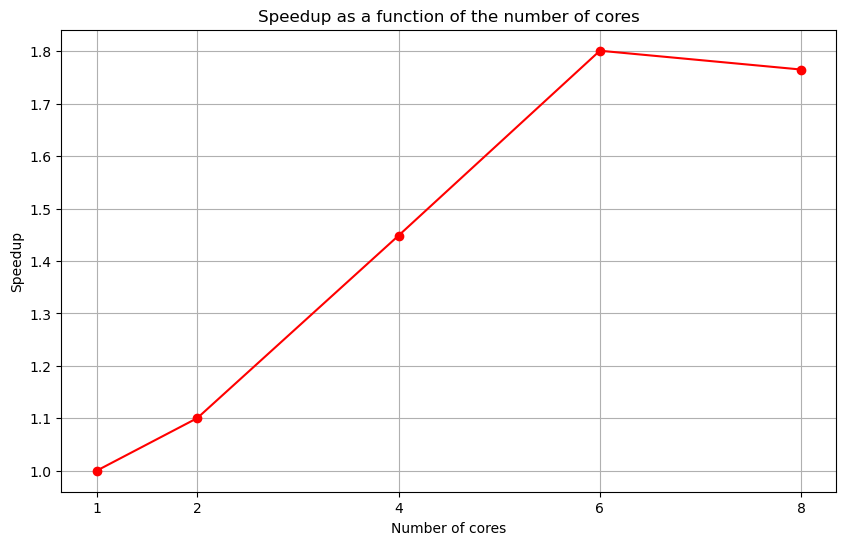

In [20]:
speed = [257.66 / t for t in times]

plt.figure(figsize=(10,6))
plt.plot(cores, speed, marker='o', linestyle='-', color='red')
plt.title("Speedup as a function of the number of cores")
plt.xlabel("Number of cores")
plt.ylabel("Speedup")
plt.xticks(cores)
plt.grid(True)
plt.show()

**AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR WITH DATAFRAMES**

We first imported essential Python libraries (numpy, pandas, and time) and enabled Apache Arrow to improve performance when converting Spark DataFrames to pandas DataFrames. This configuration significantly speeds up data transfer between both environments.

In [21]:
import numpy as np
import pandas as pd 
import time as time
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true") # compatibility between pandas as spark
# Verificar la configuración
print("Arrow enabled:", spark.conf.get("spark.sql.execution.arrow.enabled"))

Arrow enabled: true


We selected the relevant columns (tpep_pickup_datetime, tpep_dropoff_datetime, and trip_distance) from the original dataset. The same subset of data, df2, was used in the previous RDD analysis, ensuring consistency between both approaches.

In [22]:
startDataFrame= time.time()
df2.show(5)

+--------------------+---------------------+-------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|
+--------------------+---------------------+-------------+
| 2024-10-01 00:30:44|  2024-10-01 00:48:26|          3.0|
| 2024-10-01 00:12:20|  2024-10-01 00:25:25|          2.2|
| 2024-10-01 00:04:46|  2024-10-01 00:13:52|          2.7|
| 2024-10-01 00:12:10|  2024-10-01 00:23:01|          3.1|
| 2024-10-01 00:30:22|  2024-10-01 00:30:39|          0.0|
+--------------------+---------------------+-------------+
only showing top 5 rows


In this step, both pickup and dropoff timestamps were converted into UNIX time format (seconds since 1970-01-01). This allowed the calculation of each trip’s duration in seconds (duration_s), a necessary variable to compute the average taxi speed later. 
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.to_unix_timestamp.html

In [23]:
from pyspark.sql.functions import col, to_unix_timestamp, lit

fmt = "yyyy-MM-dd HH:mm:ss"  # formato de las columnas
df2_ts = (
    df2.withColumn("pu_unix", to_unix_timestamp(col("tpep_pickup_datetime"), lit(fmt)))
       .withColumn("do_unix", to_unix_timestamp(col("tpep_dropoff_datetime"), lit(fmt)))
       .withColumn("duration_s", col("do_unix") - col("pu_unix"))
)
df2_ts.take(5)

[Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 30, 44), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 48, 26), trip_distance=3.0, pu_unix=1727742644, do_unix=1727743706, duration_s=1062),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 12, 20), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 25, 25), trip_distance=2.2, pu_unix=1727741540, do_unix=1727742325, duration_s=785),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 4, 46), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 13, 52), trip_distance=2.7, pu_unix=1727741086, do_unix=1727741632, duration_s=546),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 12, 10), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 23, 1), trip_distance=3.1, pu_unix=1727741530, do_unix=1727742181, duration_s=651),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 30, 22), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 30, 39), trip_distance=0.0, pu_unix=

A new DataFrame was created from the previous one by converting the trip duration from seconds to hours and computing the average speed for each trip. The distance, originally in miles, was converted to kilometers per hour (km/h) using a conversion factor of 1.60934.

In [24]:
from pyspark.sql.functions import col

df_speed = (
    df2_ts
    .withColumn("duration_h", col("duration_s") / 3600.0)
    .withColumn("speed_kmh", (col("trip_distance") / col("duration_h")) * 1.60934)
)

df_speed.select("trip_distance", "duration_h", "speed_kmh").show(5)

+-------------+--------------------+------------------+
|trip_distance|          duration_h|         speed_kmh|
+-------------+--------------------+------------------+
|          3.0|               0.295|16.366169491525426|
|          2.2| 0.21805555555555556| 16.23690802547771|
|          2.7| 0.15166666666666667| 28.64978901098901|
|          3.1| 0.18083333333333335|27.588685714285713|
|          0.0|0.004722222222222222|               0.0|
+-------------+--------------------+------------------+
only showing top 5 rows


We filtered the DataFrame to remove null or unrealistic values, keeping only reasonable trips according to the criteria previously established in the RDD section to maintain consistency between both approaches.

In [25]:
df_clean = df_speed.filter(
    (col("duration_s") > 30) &              # al menos medio minuto
    (col("trip_distance") > 0) &          # mas de 0 millas
    (col("speed_kmh") > 0) & (col("speed_kmh") < 150)                # velocidad razonable <150 km/h
)

We added a new column indicating the hour at which each trip starts, which will later allow grouping by time of day. The necessary functions were imported, following the official Spark documentation available at
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.to_unix_timestamp.html and
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.hour.html

In [26]:
from pyspark.sql.functions import from_unixtime, hour

df_hour = df_clean.withColumn("hour_of_day", hour(from_unixtime(col("pu_unix")))) #a q hora comienza el viaje 
df_hour.select("tpep_pickup_datetime", "hour_of_day", "speed_kmh").show(10)

+--------------------+-----------+------------------+
|tpep_pickup_datetime|hour_of_day|         speed_kmh|
+--------------------+-----------+------------------+
| 2024-10-01 00:30:44|          0|16.366169491525426|
| 2024-10-01 00:12:20|          0| 16.23690802547771|
| 2024-10-01 00:04:46|          0| 28.64978901098901|
| 2024-10-01 00:12:10|          0|27.588685714285713|
| 2024-10-01 00:31:20|          0|20.070768857142856|
| 2024-10-01 00:42:57|          0|20.691514285714288|
| 2024-10-01 00:59:55|          0|19.441691275167784|
| 2024-10-01 00:00:47|          0|29.641797209302325|
| 2024-10-01 00:17:36|          0|24.231887452471486|
| 2024-10-01 00:49:00|          0|         17.380872|
+--------------------+-----------+------------------+
only showing top 10 rows


With this new column, we can now group all trips by their starting hour to prepare for the calculation of average speed per hour.

In [27]:
df_grouped = df_hour.groupBy("hour_of_day")

We calculated the average speed and the total number of trips for each hour of the day, obtaining the mean taxi speed distribution throughout the 24-hour period.

In [28]:
from pyspark.sql.functions import avg, count

df_stats = df_grouped.agg(
    avg("speed_kmh").alias("avg_speed_kmh"),
    count("*").alias("n_trips")
)
df_stats.show(10)

+-----------+------------------+-------+
|hour_of_day|     avg_speed_kmh|n_trips|
+-----------+------------------+-------+
|         12|15.465083071695371|2140703|
|         22|20.125957418990346|2190640|
|          1|22.340565531609666| 752903|
|         13|15.504971294327246|2227096|
|          6|25.985972371226183| 570906|
|         16|14.889239071618755|2491740|
|          3| 24.30748928412103| 319048|
|         20| 18.73804871619756|2320697|
|          5|31.401370846483214| 253817|
|         19|17.119570433391782|2531026|
+-----------+------------------+-------+
only showing top 10 rows


We rounded the average speed values to two decimal places and ordered the results in ascending order by hour of the day to clearly display the hourly evolution of taxi speeds.

In [29]:
from pyspark.sql.functions import round

df_avg_speed = (
    df_stats
    .withColumn("avg_speed_kmh", round(col("avg_speed_kmh"), 2))
    .orderBy("hour_of_day")
)
df_avg_speed.show(24, truncate=False)


+-----------+-------------+-------+
|hour_of_day|avg_speed_kmh|n_trips|
+-----------+-------------+-------+
|0          |22.67        |1164656|
|1          |22.34        |752903 |
|2          |22.43        |488733 |
|3          |24.31        |319048 |
|4          |29.14        |232110 |
|5          |31.4         |253817 |
|6          |25.99        |570906 |
|7          |20.62        |1110685|
|8          |17.45        |1534013|
|9          |16.93        |1680799|
|10         |16.49        |1802441|
|11         |15.61        |1958873|
|12         |15.47        |2140703|
|13         |15.5         |2227096|
|14         |15.11        |2388975|
|15         |14.7         |2466595|
|16         |14.89        |2491740|
|17         |14.72        |2730473|
|18         |15.47        |2864870|
|19         |17.12        |2531026|
|20         |18.74        |2320697|
|21         |19.5         |2368132|
|22         |20.13        |2190640|
|23         |21.76        |1697748|
+-----------+-------------+-

In [30]:
df_avg_speed.printSchema()

root
 |-- hour_of_day: integer (nullable = true)
 |-- avg_speed_kmh: double (nullable = true)
 |-- n_trips: long (nullable = false)



We converted the Spark DataFrame into a pandas DataFrame using Apache Arrow to enable faster data transfer and easier visualization of the resulting table in Python.

In [31]:
# Convertimos a pandas usando Arrow
df_avg_pd = df_avg_speed.toPandas()

# Mostrar tabla
print(df_avg_pd.head())

   hour_of_day  avg_speed_kmh  n_trips
0            0          22.67  1164656
1            1          22.34   752903
2            2          22.43   488733
3            3          24.31   319048
4            4          29.14   232110


We visualized the results using Matplotlib, plotting the average taxi speed (in km/h) against the hour of the day to observe the hourly variation in traffic conditions throughout the day.

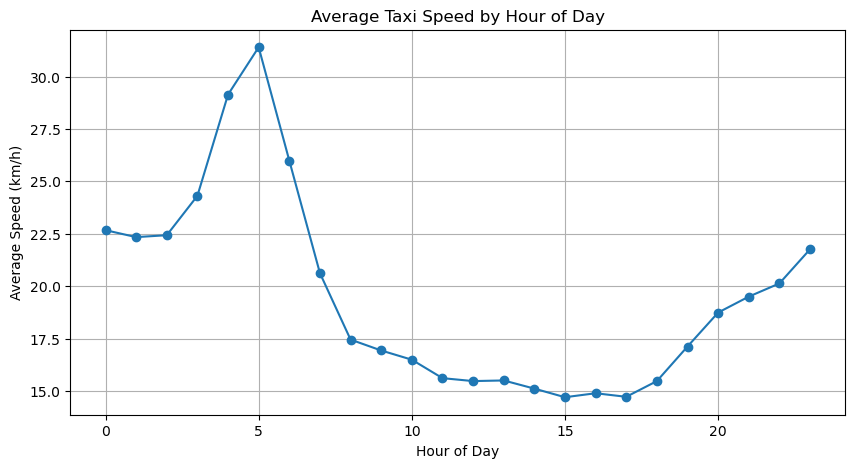

In [32]:
# Visualizar
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_avg_pd["hour_of_day"], df_avg_pd["avg_speed_kmh"], marker="o")
plt.title("Average Taxi Speed by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (km/h)")
plt.grid(True)
plt.show()

In [33]:
endDataFrame = time.time()
print(f"Execution time: {endDataFrame - startDataFrame:.2f} s")

Execution time: 42.67 s


**AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR WITH SQL**

In this final part of the study, we applied Spark SQL to perform the same analysis as before, demonstrating how the same problem can be addressed through direct SQL queries on Spark DataFrames.

We repeated the same data-cleaning process as in the previous section to ensure consistent filtering before comparing performance across methods. In this case, the execution time of the SQL approach was measured by starting a timer (startSQL = time.time()). The pickup and dropoff timestamps were again converted into UNIX time format to calculate the trip duration in seconds, allowing a fair comparison of computational efficiency between the DataFrame and SQL implementations.

In [34]:
startSQL= time.time()
fmt = "yyyy-MM-dd HH:mm:ss"  # formato de las columnas
df2_ts = (
    df2.withColumn("pu_unix", to_unix_timestamp(col("tpep_pickup_datetime"), lit(fmt)))
       .withColumn("do_unix", to_unix_timestamp(col("tpep_dropoff_datetime"), lit(fmt)))
       .withColumn("duration_s", col("do_unix") - col("pu_unix"))
)
df2_ts.take(5)

[Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 30, 44), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 48, 26), trip_distance=3.0, pu_unix=1727742644, do_unix=1727743706, duration_s=1062),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 12, 20), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 25, 25), trip_distance=2.2, pu_unix=1727741540, do_unix=1727742325, duration_s=785),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 4, 46), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 13, 52), trip_distance=2.7, pu_unix=1727741086, do_unix=1727741632, duration_s=546),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 12, 10), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 23, 1), trip_distance=3.1, pu_unix=1727741530, do_unix=1727742181, duration_s=651),
 Row(tpep_pickup_datetime=datetime.datetime(2024, 10, 1, 0, 30, 22), tpep_dropoff_datetime=datetime.datetime(2024, 10, 1, 0, 30, 39), trip_distance=0.0, pu_unix=

We created a temporary SQL view named "taxi_trips" from the existing DataFrame. This enables the use of SQL queries directly on the Spark DataFrame, treating it as a relational table within the Spark session.

In [35]:
df2_ts.createOrReplaceTempView("taxi_trips")

Spark creates a new temporary view called taxi_clean, which contains all the original columns from the dataset along with two newly calculated ones: duration_h (trip duration in hours) and speed_kmh (average speed in km/h). The view also applies several filters to exclude trips with unrealistic durations, distances, or speeds, ensuring that only valid and consistent records are kept for analysis.

In [36]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW taxi_clean AS
    SELECT *,
        (duration_s / 3600.0) AS duration_h,
        (trip_distance / (duration_s / 3600.0)) * 1.60934 AS speed_kmh
    FROM taxi_trips
    WHERE 
        duration_s > 30 AND
        trip_distance > 0 AND
        (trip_distance / (duration_s / 3600.0)) * 1.60934 BETWEEN 0 AND 150
""")


DataFrame[]

We displayed a sample of five rows from the taxi_clean view to verify that the new columns (duration_s and speed_kmh) were correctly calculated and that the data cleaning process was successfully applied.

In [37]:
spark.sql("SELECT tpep_pickup_datetime, trip_distance, duration_s, speed_kmh FROM taxi_clean LIMIT 5").show()

+--------------------+-------------+----------+------------------+
|tpep_pickup_datetime|trip_distance|duration_s|         speed_kmh|
+--------------------+-------------+----------+------------------+
| 2024-10-01 00:30:44|          3.0|      1062|16.366169491525426|
| 2024-10-01 00:12:20|          2.2|       785| 16.23687493121033|
| 2024-10-01 00:04:46|          2.7|       546|28.649726044558147|
| 2024-10-01 00:12:10|          3.1|       651| 27.58873656909967|
| 2024-10-01 00:31:20|         0.97|       280| 20.07071151225282|
+--------------------+-------------+----------+------------------+



This SQL query calculates the average taxi speed as a function of the hour of the day using the previously cleaned dataset (taxi_clean). It extracts the pickup hour (hour_of_day) from each trip’s timestamp and then computes two aggregated values: the average speed (avg_speed_kmh) and the total number of trips (n_trips) for that hour. Finally, the results are ordered in ascending order by hour to clearly display the hourly variation in taxi speeds throughout the day.

In [38]:
df_avg_speed_sql = spark.sql("""
    SELECT 
        HOUR(tpep_pickup_datetime) AS hour_of_day,
        ROUND(AVG(speed_kmh), 2) AS avg_speed_kmh,
        COUNT(*) AS n_trips
    FROM taxi_clean
    GROUP BY hour_of_day
    ORDER BY hour_of_day ASC
""")

df_avg_speed_sql.show(24, truncate=False)


+-----------+-------------+-------+
|hour_of_day|avg_speed_kmh|n_trips|
+-----------+-------------+-------+
|0          |22.67        |1164656|
|1          |22.34        |752903 |
|2          |22.43        |488733 |
|3          |24.31        |319048 |
|4          |29.14        |232110 |
|5          |31.4         |253817 |
|6          |25.99        |570906 |
|7          |20.62        |1110685|
|8          |17.45        |1534013|
|9          |16.93        |1680799|
|10         |16.49        |1802441|
|11         |15.61        |1958873|
|12         |15.47        |2140703|
|13         |15.5         |2227096|
|14         |15.11        |2388975|
|15         |14.7         |2466595|
|16         |14.89        |2491740|
|17         |14.72        |2730473|
|18         |15.47        |2864870|
|19         |17.12        |2531026|
|20         |18.74        |2320697|
|21         |19.5         |2368132|
|22         |20.13        |2190640|
|23         |21.76        |1697748|
+-----------+-------------+-

We visualized the results using Matplotlib by plotting the average taxi speed (in km/h) against the hour of the day. This graphical representation allows us to observe how taxi speeds vary throughout the 24-hour period, highlighting slower speeds during peak traffic hours and higher speeds during nighttime when traffic density is lower.

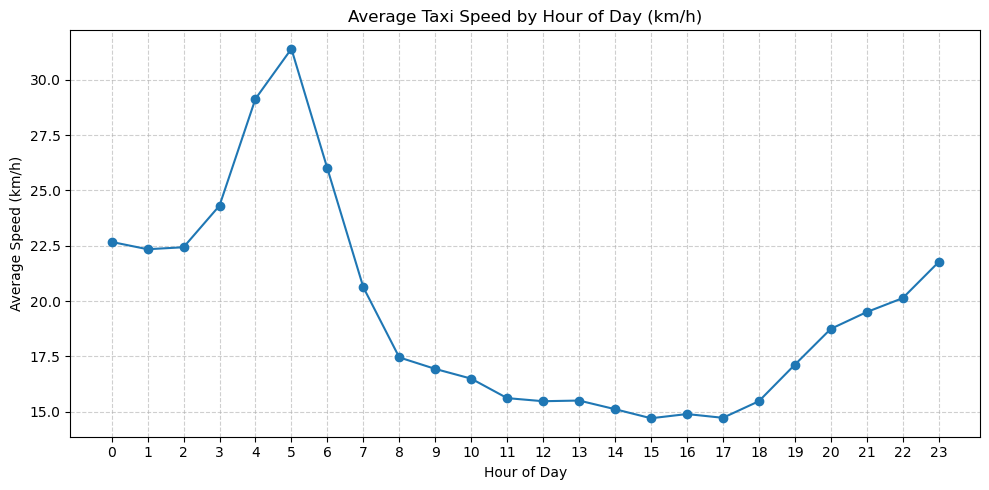

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_avg_pd["hour_of_day"], df_avg_pd["avg_speed_kmh"], marker="o", color="tab:blue")

plt.title("Average Taxi Speed by Hour of Day (km/h)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (km/h)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [40]:
endSQL = time.time()
print(f"Execution time: {endSQL - startSQL:.2f} s")

Execution time: 34.12 s


    Comparison of execution times:

In [41]:
print(f"Execution time with RDD: {end - start:.2f} s")
print(f"Execution time with DataFrames: {endDataFrame - startDataFrame:.2f} s")
print(f"Execution time with SQL: {endSQL - startSQL:.2f} s")

Execution time with RDD: 132.73 s
Execution time with DataFrames: 42.67 s
Execution time with SQL: 34.12 s


We can observe that the fastest approach is using SQL queries. This occurs because the program internally optimizes the queries. In contrast using RDDs is the slowest method. In particular, the slowest step is the reduceByKey. Different repartitions were tested but the execution time did not improve.


**MOST FREQUENT TAXI TRIPS**

In this part of the project, we are looking for the most common trips that took place in NYC by taxi. For the sake of this study, among all the variables of this dataframe, only the pick-up and drop-off locations will be necessary. Thus, only those columns are selected.

In [42]:
dff=df.select(["PULocationID","DOLocationID"])
rddf = dff.rdd

In [43]:
dff.show(5)

+------------+------------+
|PULocationID|DOLocationID|
+------------+------------+
|         162|         246|
|          48|         236|
|         142|          24|
|         233|          75|
|         262|         262|
+------------+------------+
only showing top 5 rows


The next step is to upload the dataframe "taxi_zone_lookup.csv", which will allow us to translate
the different location IDs to real NYC locations.

In [44]:
dfloc = spark.read.format("csv").option("inferSchema", "true").option("header", "true").option("mode", "DROPMALFORMED").load("taxi_zone_lookup.csv")
dfloc.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows


Now, we have to modify some particular entries of the dfloc dataset, since their value is N/A, and it can be problematic when processing the data.

In [45]:
from pyspark.sql.functions import when, col

dfloc = dfloc.withColumn("Borough",
    when(col("LocationID") == 264, "Non-registered location").otherwise(col("Borough")))

dfloc = dfloc.withColumn("Zone",
    when(col("LocationID") == 264, "Non-registered location").otherwise(col("Zone")))

dfloc = dfloc.withColumn("Borough",
    when(col("LocationID") == 265, "Outside of NYC").otherwise(col("Borough")))

We start measuring the execution time.

In [46]:
import time

start_trip = time.time()

Next, it is time to apply the MapReduce paradigm to the first RDD, which will allow us to count the number of trips that start in a particular location and end up in another one.

In [47]:
rdd2aux = rddf.map(lambda x: (x,1))
rdd2aux.take(5)

[(Row(PULocationID=162, DOLocationID=246), 1),
 (Row(PULocationID=48, DOLocationID=236), 1),
 (Row(PULocationID=142, DOLocationID=24), 1),
 (Row(PULocationID=233, DOLocationID=75), 1),
 (Row(PULocationID=262, DOLocationID=262), 1)]

In [48]:
rddfinal = rdd2aux.reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)
rddfinal.take(5)

[(Row(PULocationID=237, DOLocationID=236), 279894),
 (Row(PULocationID=236, DOLocationID=237), 241425),
 (Row(PULocationID=237, DOLocationID=237), 196947),
 (Row(PULocationID=236, DOLocationID=236), 191380),
 (Row(PULocationID=161, DOLocationID=237), 131903)]

We present the results of the MapReduce process in a more comprehensible way.

In [49]:
flattened_rddf = rddfinal.map(lambda x: (x[0].PULocationID, x[0].DOLocationID, x[1]))
dfi = flattened_rddf.toDF(["PULocationID", "DOLocationID", "number_of_trips"])
dfi.show(5)

+------------+------------+---------------+
|PULocationID|DOLocationID|number_of_trips|
+------------+------------+---------------+
|         237|         236|         279894|
|         236|         237|         241425|
|         237|         237|         196947|
|         236|         236|         191380|
|         161|         237|         131903|
+------------+------------+---------------+
only showing top 5 rows


Next, we need to make a join with the dfloc dataframe, so that the location IDs can be translated to real-life NYC locations.

In [50]:
from pyspark.sql.functions import concat, lit

dfPUloc = dfloc.withColumnRenamed("LocationID", "PULocationID").withColumn("PU_Borough_&_Zone",concat(dfloc["Borough"], lit("-"), dfloc["Zone"])).select(["PULocationID","PU_Borough_&_Zone"])
dfPU = dfi.join(dfPUloc, on =["PULocationID"])

dfDOloc = dfloc.withColumnRenamed("LocationID", "DOLocationID").withColumn("DO_Borough_&_Zone",concat(dfloc["Borough"], lit("-"), dfloc["Zone"])).select(["DOLocationID","DO_Borough_&_Zone"])
dfPUDO = dfPU.join(dfDOloc, on = ["DOLocationID"])
dfPUDO.show(10)

+------------+------------+---------------+--------------------+--------------------+
|DOLocationID|PULocationID|number_of_trips|   PU_Borough_&_Zone|   DO_Borough_&_Zone|
+------------+------------+---------------+--------------------+--------------------+
|         236|         237|         279894|Manhattan-Upper E...|Manhattan-Upper E...|
|         237|         236|         241425|Manhattan-Upper E...|Manhattan-Upper E...|
|         237|         237|         196947|Manhattan-Upper E...|Manhattan-Upper E...|
|         236|         236|         191380|Manhattan-Upper E...|Manhattan-Upper E...|
|         237|         161|         131903|Manhattan-Midtown...|Manhattan-Upper E...|
|         161|         237|         117112|Manhattan-Upper E...|Manhattan-Midtown...|
|         236|         161|         109747|Manhattan-Midtown...|Manhattan-Upper E...|
|         162|         237|         107499|Manhattan-Upper E...|Manhattan-Midtown...|
|         142|         239|         105687|Manhattan-U

We convert the result to Pandas to make them easier to read.

In [51]:
dfFinal = dfPUDO.select(["PU_Borough_&_Zone","DO_Borough_&_Zone","number_of_trips"])
dfFinal = dfFinal.toPandas()
dfFinal

,PU_Borough_&_Zone,DO_Borough_&_Zone,number_of_trips
0,Manhattan-Upper East Side South,Manhattan-Upper East Side North,279894
1,Manhattan-Upper East Side North,Manhattan-Upper East Side South,241425
2,Manhattan-Upper East Side South,Manhattan-Upper East Side South,196947
3,Manhattan-Upper East Side North,Manhattan-Upper East Side North,191380
4,Manhattan-Midtown Center,Manhattan-Upper East Side South,131903
...,...,...,...
50513,Queens-Auburndale,Manhattan-Upper East Side North,1
50514,Queens-Glendale,Brooklyn-Kensington,1
50515,Staten Island-Saint George/New Brighton,Manhattan-West Village,1
50516,Queens-Douglaston,Brooklyn-Cypress Hills,1


Finally, we make a histogram with the top 10 most common trips in NYC.

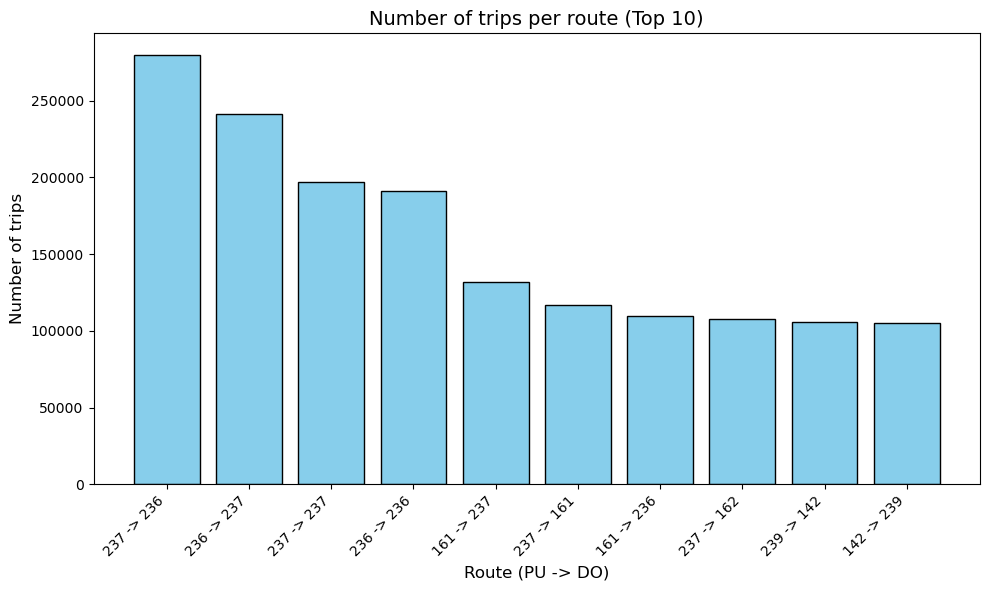

In [52]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws, col

df_plot = dfPUDO.withColumn(
    "ruta", concat_ws(" -> ", col("PULocationID"), col("DOLocationID"))
).select("ruta", "number_of_trips")

df_top10 = df_plot.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_top10["ruta"], df_top10["number_of_trips"], color="skyblue", edgecolor="black")

plt.title("Number of trips per route (Top 10)", fontsize=14)
plt.xlabel("Route (PU -> DO)", fontsize=12)
plt.ylabel("Number of trips", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [53]:
end_trip = time.time()
print(f"Execution time: {end_trip - start_trip:.2f} s")

Execution time: 80.21 s


**ECONOMIC ANALYSIS**

*Analysis 1*

In this part of the analysis, financial records are examined to evaluate tipping patterns. Specifically, the average card tip amounts, derived from the tip_amount variable, are computed for each route, defined as a specific combination of pickup (PU) and drop-off (DO) locations. This allows for the identification of the ten routes associated with the highest average card tip values.

In addition, the execution time required to process the data is recorded. For this purpose, the start time is initialized using the time library.

In [54]:
import time

start = time.time()

The data is cleaned following the same procedure as in the previous analysis. In particular, the isNotNull() filter is applied to retain only rows where the tip_amount is defined, thereby excluding any entries with missing values, and trips with location ID 264 are also removed, as this corresponds to an unknown zone.

In [55]:
from pyspark.sql.functions import col

# Clean database, that is, remove zero-distance trips, same pickup/dropoff, and removing null tip amounts
base4 = (df
       .filter(col("tpep_pickup_datetime") != col("tpep_dropoff_datetime"))
       .filter(col("trip_distance") > 0)
       .filter(col("tip_amount").isNotNull()) 
      )

At this stage, the columns of interest are selected using the select transformation. For the analysis, only the columns corresponding to the pickup and drop-off locations, as well as the tip amount for that trip, are retained. Moreover, this new dataframe is transformed into an RDD to take advantage of the Spark resources.

In [56]:
#selecting the columns of interest
rdd_tip=base4.select("PULocationID","DOLocationID", "tip_amount").rdd 
rdd_tip.take(5)

[Row(PULocationID=162, DOLocationID=246, tip_amount=1.5),
 Row(PULocationID=48, DOLocationID=236, tip_amount=3.8),
 Row(PULocationID=142, DOLocationID=24, tip_amount=3.7),
 Row(PULocationID=233, DOLocationID=75, tip_amount=2.0),
 Row(PULocationID=137, DOLocationID=137, tip_amount=2.44)]

The average card tip amount for each route is now computed. To this end, the RDD is prepared for processing using the map transformation. Each key is defined as the pair of pickup (PU) and drop-off (DO) locations, while each value is represented as a vector containing the tip amount (in float format) and a count of 1, facilitating subsequent aggregation.

Furthermore, the reduceByKey transformation is used to aggregate the total tip amount and the count of trips for each route. The average tip amount for each PU–DO pair is then calculated by dividing the total tip by the corresponding count and stored in the variable avg_tip.

In [57]:
# Preparing the data for making counts
rdd_pairs_tip = rdd_tip.map(lambda x: ((x.PULocationID, x.DOLocationID), (float(x.tip_amount), 1)))

# Sum tip_amount and count per route (preparation for calculating the average)
sums_counts_tip = rdd_pairs_tip.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# Compute average tip per each of the routes
avg_tip = sums_counts_tip.mapValues(lambda x: x[0]/x[1])

The next step is to identify the ten routes with the highest average card tips. To achieve this, the sortBy transformation is applied using the average tip amount as the sorting key, and the take function is then used to retrieve precisely the ten desired routes.

In [58]:
# Take the top 10 routes by average card tips
top10_tip = avg_tip.sortBy(lambda x: x[1], ascending=False).take(10)

Finally, the RDD is converted into a pandas DataFrame to facilitate the visualization process. An additional column, PU_DO, is defined to improve the readability of the x-axis labels in the plot. A horizontal bar chart is then employed to clearly display the differences in average card tips across routes.

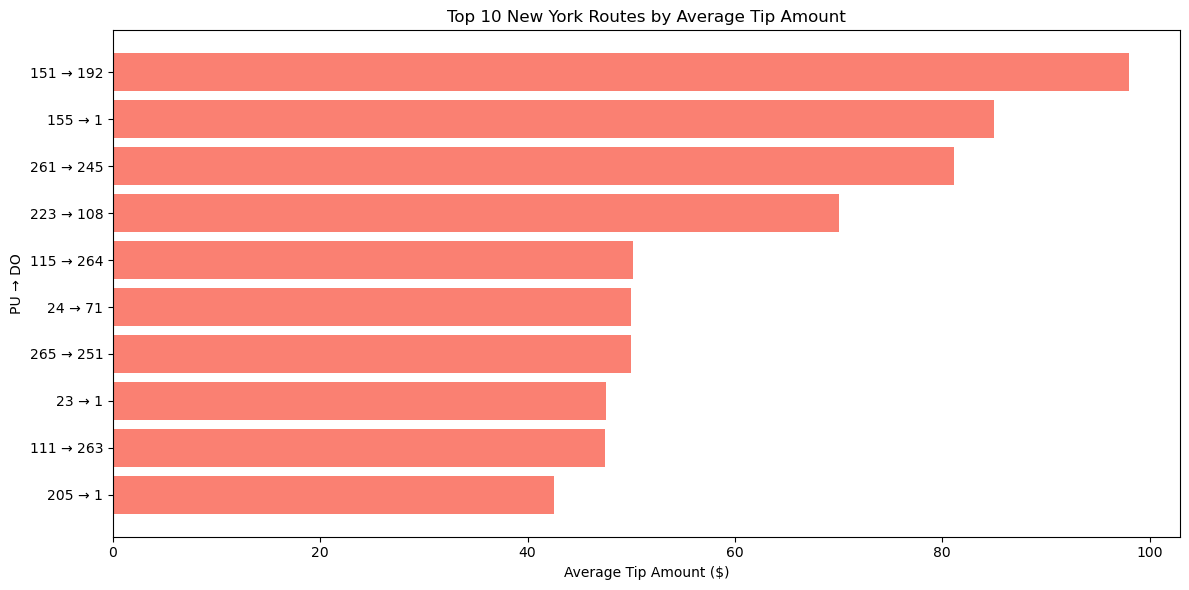

In [59]:
# Convert to Pandas for plotting 
import pandas as pd
top10_tip_df = pd.DataFrame(top10_tip, columns=['route', 'avg_tip'])
#What is done here is to stablish a new column appropiate for the x axis label
top10_tip_df["PU_DO"] = top10_tip_df['route'].apply(lambda x: f"{x[0]} → {x[1]}")

# Plot horizontal bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.barh(top10_tip_df["PU_DO"], top10_tip_df["avg_tip"], color='salmon')
plt.xlabel("Average Tip Amount ($)")
plt.ylabel("PU → DO")
plt.title("Top 10 New York Routes by Average Tip Amount")
plt.gca().invert_yaxis()  # inverse order (highest on top)
plt.tight_layout()
plt.show()

Therefore, it is notable that the route between location IDs 224 and 227 exhibits the highest average card tip amounts. By examining the joined DataFrame from the previous analysis, this route is identified as running from Manhattan’s Stuyvesant Town/Peter Cooper Village to Brooklyn’s Sunset Park East.

In the last line, the time of execution is calculated and shown by making the end time minus the start time.

In [60]:
end = time.time()
print(f"Execution time: {end - start:.2f} s")

Execution time: 117.09 s


*Analysis 2*

In this second analysis, the hours of the day that provide the most benefits per minute of driving will be discussed.

In [61]:
start_eco = time.time()

First, a new column with the duration of each trip in minutes is calculated.

In [62]:
from pyspark.sql import functions as F

dfEco = df.withColumn(
    "trip_duration_min",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60
)
dfEco = dfEco.filter((F.col("trip_duration_min") > 1) & (F.col("total_amount") > 0))

Now, the total income per minute is calculated.

In [63]:
dfEco2 = dfEco.withColumn("income_per_minute", F.col("total_amount") / F.col("trip_duration_min"))

Furthermore, a new column with the hour each trip starts is added.

In [64]:
dfEco3 = dfEco2.withColumn("hour_of_the_day", F.hour("tpep_pickup_datetime"))

A new dataframe is created including all the relevant data.

In [65]:
efficiency_per_hour = (
    dfEco3.groupBy("hour_of_the_day")
      .agg(
          F.count("*").alias("Number of trips"),
          F.avg("income_per_minute").alias("Average income per minute"),
          F.avg("total_amount").alias("Average income per trip"),
          F.avg("trip_duration_min").alias("Average duration of the trip")
      )
      .orderBy("hour_of_the_day")
)

efficiency_per_hour.show(24)

+---------------+---------------+-------------------------+-----------------------+----------------------------+
|hour_of_the_day|Number of trips|Average income per minute|Average income per trip|Average duration of the trip|
+---------------+---------------+-------------------------+-----------------------+----------------------------+
|              0|        1154458|       2.2073836630544026|     28.601308752677994|          15.546199905063654|
|              1|         746076|        2.251011551748004|      25.99260281794316|           14.35373022766221|
|              2|         483943|       2.2967461171255286|     24.378307217998564|           13.37985771740337|
|              3|         315284|        2.396529527110457|     25.625009959274514|           13.41611610484516|
|              4|         230325|       2.5412271602010463|     31.939303375664586|           15.33522848149357|
|              5|         252516|       2.6210483029200597|     36.937685532796955|          17.

Finally, a histogram with the average income per minute for each hour is plotted.

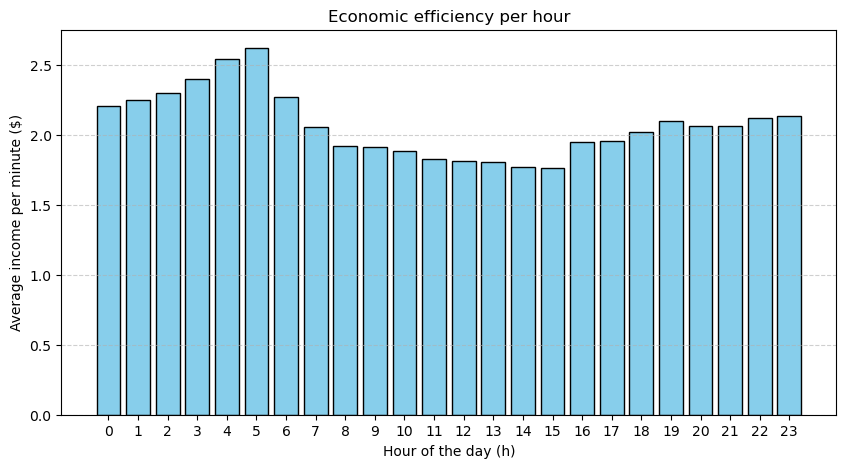

In [66]:
import matplotlib.pyplot as plt

pdfff = efficiency_per_hour.toPandas()

plt.figure(figsize=(10,5))
plt.bar(pdfff["hour_of_the_day"], pdfff["Average income per minute"], color="skyblue", edgecolor="black")
plt.xticks(range(0,24))
plt.xlabel("Hour of the day (h)")
plt.ylabel("Average income per minute ($)")
plt.title("Economic efficiency per hour")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [67]:
end_eco = time.time()
print(f"Execution time: {end_eco - start_eco:.2f} s")

Execution time: 9.91 s
